In [1]:
from windData import WindDataCollector
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import math
import pandas as pd

from influxdb import InfluxDBClient

import datetime

In [2]:
def eval_metrics(actual, pred):
	rmse = np.sqrt(mean_squared_error(actual, pred))
	mae = mean_absolute_error(actual, pred)
	r2 = r2_score(actual, pred)
	return rmse, mae, r2


In [3]:
start_time = datetime.datetime(2021, 1, 1, 0, 0, 0).strftime("'%Y-%m-%dT%H:%M:%SZ'")


dataCollector = WindDataCollector()

gen_df = dataCollector.getGenerationData(now = start_time, delta="90")
wind_df = dataCollector.getWindData(now = start_time, delta="90")

gen_df_alligned = pd.merge_asof(wind_df,gen_df,left_index=True, right_index=True)

In [4]:
train_length = int(len(gen_df_alligned)*0.9)

train_X = gen_df_alligned.iloc[:train_length][[
#    "Direction",
    "Speed"]]
test_X = gen_df_alligned.iloc[train_length:][[
#    "Direction",
    "Speed"]]

train_y = gen_df_alligned.iloc[:train_length]["Total"]
test_y = gen_df_alligned.iloc[train_length:]["Total"]

## MLP

https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html

### Data prep and functions

In [5]:
normalizer = tf.keras.layers.Normalization(axis=-1)
windspeed = train_X["Speed"].to_numpy()
windspeed_normalizer = layers.Normalization(input_shape=[1,], axis=None)
windspeed_normalizer.adapt(windspeed)

In [6]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 15])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

In [7]:
def build_and_compile_model_GD(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(32, activation='relu'),
      layers.Dense(16, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.compat.v1.train.GradientDescentOptimizer(0.1))
  return model


def build_and_compile_model_SGD(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(32, activation='relu'),
      layers.Dense(16, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.experimental.SGD(0.1))
  return model

## Gradient descent

In [8]:
dnn_windspeed_model_GD = build_and_compile_model_GD(windspeed_normalizer)

In [9]:
power = dnn_windspeed_model_GD.fit(
    train_X['Speed'],
    train_y,
    validation_split=0.2,
    verbose=0, epochs=10)

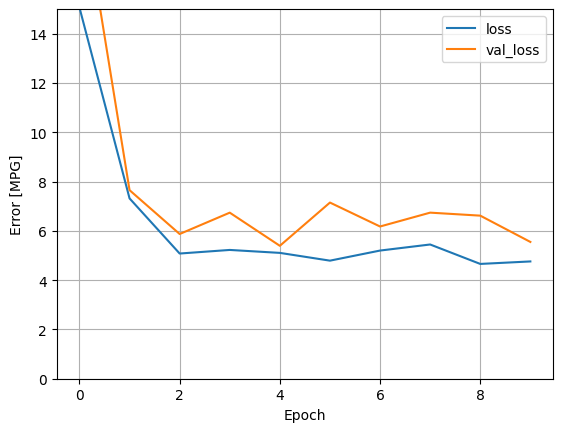

In [10]:
plot_loss(power)

In [11]:
predictions = dnn_windspeed_model_GD.predict(test_X["Speed"])
(rmse, mae, r2) = eval_metrics(test_y, predictions)
print("  RMSE: %s" % rmse)
print("  MAE: %s" % mae)
print("  R2: %s" % r2)

2/2 [==============================] - 0s 2ms/step
  RMSE: 3.736654836853754
  MAE: 3.0017198520689465
  R2: 0.9164321703571978


## Stochastic Gradient Descent

In [12]:
dnn_windspeed_model_SGD = build_and_compile_model_SGD(windspeed_normalizer)

In [13]:
power = dnn_windspeed_model_SGD.fit(
    train_X['Speed'],
    train_y,
    validation_split=0.2,
    verbose=0, epochs=50)

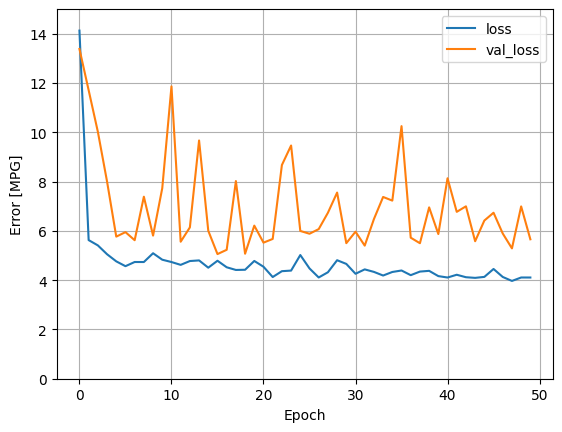

In [14]:
plot_loss(power)

In [15]:
predictions = dnn_windspeed_model_SGD.predict(test_X["Speed"])
(rmse, mae, r2) = eval_metrics(test_y, predictions)
print("  RMSE: %s" % rmse)
print("  MAE: %s" % mae)
print("  R2: %s" % r2)

2/2 [==============================] - 0s 2ms/step
  RMSE: 3.7509273878453318
  MAE: 3.0275019009920148
  R2: 0.9157925587076393
